# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import transformers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
import re
import numpy as np
import torch
import os
from tqdm import tqdm
from transformers import AutoModelForPreTraining, AutoTokenizer
import torch
import torch.nn as nn
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:

## HyperParameters
MAX_LEN=128
TRAIN_BATCH_SIZE=8
VALID_BATCH_SIZE=8
EPOCHS=10
# bert_model="sagorsarker/bangla-bert-base"

## Data Preprocessing

In [3]:

sentences,tag=[],[]
sentence_lengths=[]
text_dir="/kaggle/input/annotated-data/annotated data"

# Iterate through all the text data and and preprocess the texxt and tag
for txt in tqdm(os.listdir(text_dir)):
    with open(text_dir+"/"+txt, 'r') as file:
        temp_sentence=[]
        temp_tag=[]
        for line in file :
            
            if line!="\n":
                try:
                    temp_sentence.append(line.split()[0])
                    temp_tag.append(line.split()[1])
                except:
#                     print(line)
                    pass
            
            else:
                if len(temp_sentence)==len(temp_tag) and len(temp_sentence) >1 :
                    # Taking only if the word ccount and tag count are same and length of words >1
                    sentences.append(temp_sentence)
                    tag.append(temp_tag)
                    sentence_lengths.append(len(temp_tag))
                    

                temp_sentence=[]
                temp_tag=[]


100%|██████████| 20/20 [00:00<00:00, 85.52it/s]


In [4]:

## I am taking only 5 tags ["O","PER","TIM","LOC","ORG"]

new_tag=[]
keep=["O","PER","TIM","LOC","ORG"]
for t in tag:
    t=["PER" if "-PER" in i else i for i in t]
    t=["LOC" if "-LOC" in i else i for i in t]
    t=["TIM" if "-TIM" in i else i for i in t]
    t=["ORG" if "-ORG" in i else i for i in t]
    new_tag.append(t)


    

In [5]:
## create spaces around the puntuations to make tag length and word length to be equal
def text_process(sentence):

    punctuation_marks = ['।', ',', ';', ':', '?', '!', "'", '.', '"', '-', '[', ']', '{', '}', '(', ')', '~']


    # Define the regular expression pattern
    pattern = r"([{}])".format("".join(re.escape(mark) for mark in punctuation_marks))

    # Insert spaces before and after the punctuation marks
    modified_sentence = re.sub(pattern, r" \1 ", sentence)

    # Print the modified sentence
    return modified_sentence.strip()

### From the 2nd dataset data analysis I found that there many words are not properly tagged So I deecided to only take those sentences which have PERSON tag in it

In [6]:

sentences2=[]
tag2=[]
ct=0
o_n=[]
sentence_lengths2=[]
keep=["O","PER","TIM","LOC","ORG"]
with open('/kaggle/input/bengali-ner/banglakit_bengali-ner-data_master_main.jsonl.txt', 'r') as file:
    # Iterate over each line
    for line in file:
        # Process each line (print it in this example)
#         print(line)
        text=line.split('", [')[0][2:]
        text=text.replace("মো.","মো")
        text=text.replace("ডা.","ডা")
        text=text.replace("ড.","ড")

        text=text_process(text)
        split=text.split(" ")
        split=[s for s in split if s!='']
        notation=line.split('", [')[1][:-4]
        notation=notation[1:]
        notation=notation.split('", "')
        notation=["PER" if "-PERSON" in i else i for i in notation]
        notation=["ORG" if "-ORG" in i else i for i in notation]
        notation=["LOC" if "-GPE" in i else i for i in notation]
        notation=["TIM" if "DATE" in i else i for i in notation]
        notation=["O" if i not in keep else i for i in notation]
        if "PER" in notation and len(notation)==len(split):
            sentences2.append(split)
            tag2.append(notation)
            sentence_lengths2.append(len(split))
            ct+=1



In [7]:

ts=[]
for t in new_tag:
    ts.extend(t)
    
ts=set(ts)
ts

{'LOC', 'O', 'ORG', 'PER', 'TIM'}

In [8]:
# for i in range(800,900):
#     print(dict(zip(sentences2[i],tag2[i])))
#     print("===============================")
    

In [9]:
## merging the two datassets together
sentences.extend(sentences2)
new_tag.extend(tag2)

In [10]:
len(sentences),len(new_tag)

(7679, 7679)

### Converting the Tag values to Numerical Values

In [11]:
## Converting the Tag values to Numerical Values
tag_to_index={'O': 0,
             'PER': 1,
             'ORG':2,
             'TIM': 3,
             'LOC':4}
# tag_to_index={'O': 0,
#          'PER': 1,
#          'TIM': 2,
#          'B-LOC': 3,
#          'B-ORG': 4,
#          'I-ORG': 5,
#          'I-LOC': 6}

# Convert tags to index
tag_index =[]
for t in new_tag:
    ta=[tag_to_index[i] for i in t ]
    tag_index.append(ta)


In [12]:
# tag_index

In [13]:
len(sentences),len(tag_index)

(7679, 7679)

In [14]:
dict(zip(sentences[0],tag_index[0]))

{'\ufeffকী': 0,
 'কারণে': 0,
 'তাঁদের': 0,
 'মধ্যে': 0,
 'ঝামেলা': 0,
 'হয়েছে': 0,
 ',': 0,
 'তা': 0,
 'জানি': 0,
 'না।’': 0,
 'বরুড়া': 4,
 'থানার': 0,
 'ভারপ্রাপ্ত': 0,
 'কর্মকর্তা': 0,
 '(': 0,
 'ওসি': 0,
 ')': 0,
 'এ': 1,
 'কে': 1,
 'এম': 1,
 'কাউছার': 1,
 'চৌধুরী': 1,
 'বলেন': 0,
 '‘ঝলম': 4,
 'ইউনিয়ন': 0,
 'যুবলীগের': 2,
 'কর্মী': 0,
 'মাসুম': 1,
 'ছাত্রদলের': 2,
 'সাদ্দামকে': 1,
 'গুলি': 0,
 'করেন': 0,
 '।': 0}

## Visualizing the Tag Distribution

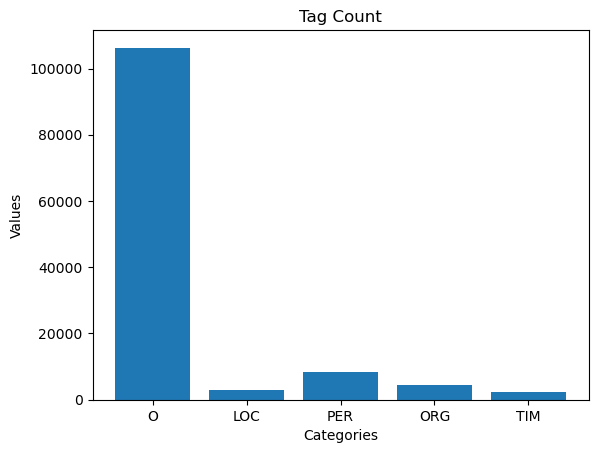

In [15]:

tags=[]
for t in new_tag :
    tags.extend(t)
tag_distribution=dict(Counter(tags))

categories = list(tag_distribution.keys())
values = list(tag_distribution.values())

plt.bar(categories, values)
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Tag Count')
plt.show()

In [16]:

bert_model="l3cube-pune/bengali-bert"
model_b = AutoModelForPreTraining.from_pretrained(bert_model)
tokenizer_b = AutoTokenizer.from_pretrained(bert_model)



Some weights of BertForPreTraining were not initialized from the model checkpoint at l3cube-pune/bengali-bert and are newly initialized: ['cls.seq_relationship.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# tokenizer_e.mask_token_id

In [17]:
input_ids=tokenizer_b.encode_plus("যুক্তরাষ্ট্রে নিয়োজিত বাংলাদেশের রাষ্ট্রদূত জিয়া উদ্দিন , জাতিসংঘে বাংলাদেশের স্থায়ী প্রতিনিধি এ কে আবদুল মোমেনসহ গুরুত্বপূর্ণ ব্যক্তিরা এ কনসার্টে উপস্থিত থাকবেন ।")["input_ids"]

In [18]:
tokenizer_b.decode(input_ids)

'[CLS] যুক্তরাষ্ট্রে নিয়োজিত বাংলাদেশের রাষ্ট্রদূত জিয়া উদ্দিন, জাতিসংঘে বাংলাদেশের স্থায়ী প্রতিনিধি এ কে আবদুল মোমেনসহ গুরুত্বপূর্ণ ব্যক্তিরা এ কনসার্টে উপস্থিত থাকবেন । [SEP]'

## Creating Dataset and Dataloader

In [19]:
class EntityDataset:
    def __init__(self,texts,tags,tokenizer,max_len):

        self.texts=texts
        self.tags=tags
        self.tokenizer=tokenizer
        self.max_len=max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = self.texts[item]
        tags = self.tags[item]


        ids = []
        target_tag =[]
        
        for i,s in enumerate(text):
            inputs=self.tokenizer.encode(
                s,
                add_special_tokens=False
            )
            
            input_len = len(inputs)
            ids.extend(inputs)
            target_tag.extend([tags[i]] * input_len)
        
            
        ids=ids[:self.max_len-2]
        target_tag=target_tag[:self.max_len-2]

        
        ids=[101] + ids + [102]
        target_tag=[0] + target_tag + [0]


        mask = [1] * len(ids)
        token_type_ids = [0] * len(ids)

        padding_len = self.max_len - len(ids)

        ids = ids + ([0] * padding_len)
        mask = mask + ([0] * padding_len)
        token_type_ids = token_type_ids + ([0] * padding_len)
        target_tag = target_tag + ([0] * padding_len)
            
        return{
            "ids" : torch.tensor(ids,dtype=torch.long),
            "mask" :torch.tensor(mask,dtype=torch.long),
            "token_type_ids":torch.tensor(token_type_ids,dtype=torch.long),
            "target_tag":torch.tensor(target_tag,dtype=torch.long)

        }


### Spliting the data into Training and Testing data 90% training data and 10 % testing data

In [20]:
from sklearn.model_selection import train_test_split
(train_sentences,test_sentences,train_tag,test_tag
) = train_test_split(
    sentences,
    tag_index, 
    random_state=42, 
    test_size=0.1
)


In [21]:
len(train_tag),len(test_tag)

(6911, 768)

In [22]:
# creating the Train and Valid Dataset and Dataloader
train_dataset = EntityDataset(
    texts=train_sentences, tags=train_tag,tokenizer=tokenizer_b,max_len=MAX_LEN
)

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=TRAIN_BATCH_SIZE, num_workers=4
)

valid_dataset = EntityDataset(
    texts=test_sentences,tags=test_tag,tokenizer=tokenizer_b,max_len=MAX_LEN
)

valid_data_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=VALID_BATCH_SIZE, num_workers=1
)

In [23]:
# Setting Up the Device Agonistic Code
device="cuda" if torch.cuda.is_available() else "cpu"

In [24]:
device

'cuda'

## Compute Performance Metrics

In [25]:
def compute_metrics(labels,pred_logits,mask):

    batch=mask.shape[0]
    pred_logits=pred_logits.argmax(2).reshape(batch,-1)

    relevant_labels = labels[mask == 1]
    relevant_pred_logits = pred_logits[mask == 1]

    return relevant_labels.tolist(),relevant_pred_logits.tolist()



## Creating The loss Function

In [26]:
def loss_fn(output, target, mask, num_labels):
    lfn = nn.CrossEntropyLoss()
    active_loss = mask.view(-1) == 1
    active_logits = output.view(-1, num_labels)
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target)
    )
    loss = lfn(active_logits, active_labels)
    return loss

## Creating the Training and Evaluation Function

In [27]:
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
def train_fn(data_loader,model,optimizer,device,scheduler):
    model.train()
    final_loss=0
    actual_labels,pred_labels=[],[]
    
    for data in tqdm(data_loader,total=len(data_loader)):
        for k,v in data.items():
            data[k]=v.to(device)
        target_tag=data["target_tag"]
        mask=data["mask"]
        
        optimizer.zero_grad()
        tag,loss=model(**data)

        relevant_labels,relevant_pred_logits=compute_metrics(target_tag,tag,mask)
        actual_labels.extend(relevant_labels)
        pred_labels.extend(relevant_pred_logits)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        final_loss+=loss.item()
    f1_sc=f1_score(actual_labels,pred_labels,average="weighted")
    accuracy=accuracy_score(actual_labels,pred_labels)
    return final_loss/len(data_loader),accuracy,f1_sc


def eval_fn(data_loader,model,device):
    model.eval()
    final_loss=0
    actual_labels,pred_labels=[],[]
    
    for data in tqdm(data_loader,total=len(data_loader)):
        for k,v in data.items():
            data[k]=v.to(device)
        target_tag=data["target_tag"]
        mask=data["mask"]
        optimizer.zero_grad()
        tag,loss=model(**data)
        relevant_labels,relevant_pred_logits=compute_metrics(target_tag,tag,mask)
        actual_labels.extend(relevant_labels)
        pred_labels.extend(relevant_pred_logits)

        final_loss+=loss.item()
    f1_sc=f1_score(actual_labels,pred_labels,average="weighted")
    accuracy=accuracy_score(actual_labels,pred_labels)
    return final_loss/len(data_loader),accuracy,f1_sc



## Creating The model

In [28]:

from transformers import AutoModelForPreTraining, AutoTokenizer
class EntityModel(nn.Module):
    def __init__(self,num_tag,bert_model=bert_model):
        super(EntityModel,self).__init__()
        self.num_tag=num_tag
        self.bert=transformers.BertModel.from_pretrained(bert_model)
#         for param in self.bert.parameters():
#             param.requires_grad=False
        self.drop1=nn.Dropout(0.3)
#         self.hidden1=nn.Linear(768,256)
        self.out_tag=nn.Linear(768,num_tag)
        
    
    def forward(self,ids,mask,token_type_ids,target_tag):
        o1=self.bert(ids,attention_mask=mask,token_type_ids=token_type_ids)
        o1=o1["last_hidden_state"]
        bo_tag=self.drop1(o1)

#         bo_tag=self.hidden1(bo_tag)
        tag=self.out_tag(bo_tag)


        loss=loss_fn(tag,target_tag,mask,self.num_tag)

        return tag,loss
    

## 2nd Model BERT_Attention_MLP

In [29]:
class Bert_BiLSTM_MLP(nn.Module):
    def __init__(self, n_tags, hidden_dim=50,num_heads=1, bert_model=bert_model):
        super(Bert_BiLSTM_MLP, self).__init__()
        self.num_tag=n_tags
        self.bert = transformers.BertModel.from_pretrained(bert_model)
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(self.bert.config.hidden_size, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(self.bert.config.hidden_size, hidden_dim)
        self.out=nn.Linear(hidden_dim * 2,n_tags)
#         self.crf = CRF(n_tags)

    def forward(self, ids,mask,token_type_ids,target_tag):
        bert_output = self.bert(ids,attention_mask=mask,token_type_ids=token_type_ids)
        bert_output=bert_output["last_hidden_state"]
        bi_lstm_out, _ = self.lstm(bert_output)
        out=self.out(bi_lstm_out)
        loss=loss_fn(out,target_tag,mask,self.num_tag)
        return out,loss

# Define number of tags
n_tags = len(tag_to_index)

In [30]:
class BertAttentionMLP(nn.Module):
    def __init__(self, n_tags, hidden_dim=50,num_heads=1, bert_model=bert_model):
        super(BertAttentionMLP, self).__init__()
        self.num_tag=n_tags
        self.bert = transformers.BertModel.from_pretrained(bert_model)
        self.hidden_dim = hidden_dim
        self.attention = nn.MultiheadAttention(self.bert.config.hidden_size, num_heads=num_heads)
#         self.lstm = nn.LSTM(self.bert.config.hidden_size, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(self.bert.config.hidden_size, hidden_dim)
        self.out=nn.Linear(hidden_dim,n_tags)
#         self.crf = CRF(n_tags)

    def forward(self, ids,mask,token_type_ids,target_tag):
        bert_output = self.bert(ids,attention_mask=mask,token_type_ids=token_type_ids)
        bert_output=bert_output["last_hidden_state"]
        attention_output, _ = self.attention(bert_output, bert_output, bert_output)
#         print(attention_output.shape)
        dense_output = self.fc(attention_output)
#         crf_output = self.crf(dense_output)
        out=self.out(dense_output)
        loss=loss_fn(out,target_tag,mask,self.num_tag)
        return out,loss

# Define number of tags
n_tags = len(tag_to_index)

In [32]:
a=next(iter(train_data_loader))

In [31]:
num_tag=len(tag_to_index)
model = EntityModel(num_tag=num_tag)
# model=BertAttentionMLP(n_tags=num_tag)
# model=Bert_BiLSTM_MLP(n_tags=num_tag)
model.to(device)

Some weights of the model checkpoint at l3cube-pune/bengali-bert were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at l3cube-pune/bengali-bert and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task 

EntityModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(197285, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [32]:
# tag,loss=model(ids=a["ids"],mask=a["mask"],token_type_ids=a["token_type_ids"],target_tag=a["target_tag"])

In [33]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(
                nd in n for nd in no_decay
            )
        ],
        "weight_decay": 0.001,
    },

]

In [34]:
num_train_steps = int(
    len(train_sentences) / TRAIN_BATCH_SIZE * EPOCHS
)
optimizer = AdamW(optimizer_parameters, lr=3e-05,no_deprecation_warning=True)
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_train_steps
)

In [35]:
MODEL_PATH = "model.bin"

In [36]:
model

EntityModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(197285, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [37]:
best_loss = np.inf
for epoch in range(EPOCHS):
    train_loss ,accuracy,f1_sco= train_fn(
        train_data_loader, 
        model, 
        optimizer, 
        device, 
        scheduler
    )
    test_loss,val_acc,val_f1 = eval_fn(
        valid_data_loader,
        model,
        device
    )
    print(f"Train Loss = {train_loss} accuracy = {accuracy} f1 score = {f1_sco} Valid Loss = {test_loss} Valid accuracy = {val_acc} Valid F1 = {val_f1}")
    if test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = test_loss

100%|██████████| 96/96 [00:03<00:00, 25.54it/s]


Train Loss = 1.240081547173085 accuracy = 0.8358349638894126 f1 score = 0.7703694712124968 Valid Loss = 1.064472437525789 Valid accuracy = 0.8302231979509697 Valid F1 = 0.7532092907440024


100%|██████████| 96/96 [00:03<00:00, 25.53it/s]


Train Loss = 0.9140363777815191 accuracy = 0.8815143694785904 f1 score = 0.8416597128912954 Valid Loss = 0.8053927806516489 Valid accuracy = 0.8790706183680936 Valid F1 = 0.8387723705444398


100%|██████████| 96/96 [00:03<00:00, 24.61it/s]


Train Loss = 0.720601470520099 accuracy = 0.8917852476386731 f1 score = 0.8579447847028207 Valid Loss = 0.6529378000025948 Valid accuracy = 0.8895597024027321 Valid F1 = 0.8574395803636348


100%|██████████| 96/96 [00:03<00:00, 24.12it/s]


Train Loss = 0.5717493716489386 accuracy = 0.9302880396273882 f1 score = 0.9212095121747375 Valid Loss = 0.5267349338779846 Valid accuracy = 0.9388949871935602 Valid F1 = 0.9365625699372346


100%|██████████| 96/96 [00:03<00:00, 24.21it/s]


Train Loss = 0.4713373823022401 accuracy = 0.9559197311370122 f1 score = 0.9539357363909831 Valid Loss = 0.45396342190603417 Valid accuracy = 0.9513965117697281 Valid F1 = 0.9506863287492234


100%|██████████| 96/96 [00:03<00:00, 24.03it/s]


Train Loss = 0.4069563951170831 accuracy = 0.9672697015594833 f1 score = 0.966379015943458 Valid Loss = 0.40921539021655917 Valid accuracy = 0.9529210879375534 Valid F1 = 0.9518231874427097


100%|██████████| 96/96 [00:03<00:00, 24.31it/s]


Train Loss = 0.3632479085655952 accuracy = 0.9723336345257519 f1 score = 0.9717749871570268 Valid Loss = 0.3806408036810656 Valid accuracy = 0.9543846810586657 Valid F1 = 0.9537330517537543


100%|██████████| 96/96 [00:03<00:00, 24.26it/s]


Train Loss = 0.3335193370434421 accuracy = 0.9762274674484669 f1 score = 0.9758378312567761 Valid Loss = 0.3647703677415848 Valid accuracy = 0.9529820709842663 Valid F1 = 0.9519109057143994


100%|██████████| 96/96 [00:04<00:00, 23.74it/s]


Train Loss = 0.31491753496919517 accuracy = 0.9780801258507602 f1 score = 0.9777603029530306 Valid Loss = 0.35033176140859723 Valid accuracy = 0.9542627149652396 Valid F1 = 0.9536329911268127


100%|██████████| 96/96 [00:03<00:00, 25.21it/s]


Train Loss = 0.30470837169775256 accuracy = 0.9799392848088512 f1 score = 0.979655829799675 Valid Loss = 0.34682865797852475 Valid accuracy = 0.9562751555067691 Valid F1 = 0.9560794665645173


## Model Performances

| Model                | Train Loss | Train Accuracy | Train F1 Score | Valid Loss | Valid Accuracy | Valid F1 Score |
|----------------------|------------|----------------|----------------|------------|----------------|----------------|
| EntityModel          | 0.083      | 0.970          | 0.970          | 0.179      | 0.936          | 0.934          |
| BI LSTM MLP          | 0.061      | 0.983          | 0.983          | 0.189      | 0.946          | 0.946          |
| Bert Attention MLP   | 0.043      | 0.985          | 0.985          | 0.200      | 0.947          | 0.946          |

## Testing the model

In [38]:

def get_names(tag,tokenizer,tokenized_sentence):
    i=0
    j=0
    prev=0
    names=[]
    ones=[]
    for index,k in enumerate(tag):
        if k==1 and prev!=1:
            i=index
            prev=1
        if k==1 and prev==1:
            j=index
        elif prev==1 and k!=1:
            prev=k
            names.append(tokenizer_b.decode(tokenized_sentence[i:j+1]))
                         
    return names
    
#     names.append(tokenizer_b.decode(tokenized_sentence[1:1+3]))
    
        
        

In [49]:
MODEL_PATH="/kaggle/working/model.bin"

In [39]:
model.load_state_dict(torch.load(MODEL_PATH,map_location="cpu"))

<All keys matched successfully>

In [40]:

def decode_Name(text,model,device=device,tokenizer=tokenizer_b):
    sentence=text_process(text)
    tokenized_sentence = tokenizer_b.encode(sentence)
    sentence = sentence.split()
    test_dataset = EntityDataset(
    texts=[sentence], 
    tags=[[0] * len(sentence)],
    tokenizer=tokenizer_b,
    max_len=MAX_LEN)

    
    model.to(device)
    index_to_tag={0 :'O',
             1 : 'PER',
             2 : 'ORG',
             3 : 'TIM',
             4 : 'LOC'}
    
    with torch.no_grad():
        data = test_dataset[0]
        for k, v in data.items():
            data[k] = v.to(device).unsqueeze(0)
        tag, _ = model(**data)
        
    tag=tag.argmax(2).cpu().numpy().reshape(-1)[:len(tokenized_sentence)]
    print(tag)
    names=get_names(tag,tokenizer,tokenized_sentence)
    return names
    
    
    
    

In [41]:
outputs=decode_Name("দীপাঞ্জনা অনেকদিন ধরে কলেজ এ আসছে না ওর কি কিছু হয়েছে।",model)
outputs

[0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]


['দীপাঞ্জনা']

In [42]:
outputs=decode_Name("যুক্তরাষ্ট্রে নিয়োজিত বাংলাদেশের রাষ্ট্রদূত জিয়া উদ্দিন জাতিসংঘে বাংলাদেশের স্থায়ী প্রতিনিধি এ কে আবদুল মোমেনসহ গুরুত্বপূর্ণ ব্যক্তিরা এ কনসার্টে উপস্থিত থাকবেন ।",model)
outputs

[0 4 0 4 0 1 1 2 4 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]


['জিয়া উদ্দিন', 'এ কে আবদুল মোমেনসহ']

In [43]:
outputs=decode_Name("আফজালুর রহমান নামের এক পরীক্ষার্থী বলেন,সাহেদ ছরওয়ার হাতে প্রশ্ন দেখে তিনি ভেবেছিলেন এটি ভুয়া প্রশ্ন।",model)

[0 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]


In [44]:
outputs

['আফজালুর রহমান', 'সাহেদ ছরওয়ার']

In [45]:
for text in test_sentences[:50]:
    text=" ".join(text)
    text=text.strip()
    print(text)
    outputs=decode_Name(text,model)
    if outputs==[]:
        print("There is no name prsent in this text")
    else:
        print("The present names are ", outputs)
    print("================================")


যুক্তরাষ্ট্রে নিয়োজিত বাংলাদেশের রাষ্ট্রদূত জিয়া উদ্দিন , জাতিসংঘে বাংলাদেশের স্থায়ী প্রতিনিধি এ কে আবদুল মোমেনসহ গুরুত্বপূর্ণ ব্যক্তিরা এ কনসার্টে উপস্থিত থাকবেন ।
[0 4 0 4 0 1 1 0 2 4 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
The present names are  ['জিয়া উদ্দিন', 'এ কে আবদুল মোমেনসহ']
গতকাল মঙ্গলবার প্রধানমন্ত্রী শেখ হাসিনা সংযোগ বন্ধের আদেশ প্রত্যাহার করে নতুন সংযোগ দেওয়ার জন্য পেট্রোবাংলার প্রস্তাব অনুমোদন করেন ।
[0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 2 2 2 2 0 0 0 0 0]
The present names are  ['শেখ হাসিনা']
ইউসিবি-বিসিবি একাদশ অধিনায়ক তামিম ইকবালের অবশ্য বড় একটা অভিযোগ আছে ।
[0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
The present names are  ['তামিম ইকবালের']
পাকিস্তানের সাবেক সামরিক শাসক জেনারেল পারভেজ মোশাররফকে রাষ্ট্রদ্রোহের মামলার শুনানিতে নেওয়ার পথে তিনি গতকাল বৃহস্পতিবার আকস্মিক হূদেরাগে আক্রান্ত হন ।
[0 4 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 3 3 0 0 0 0 0 0 0 0 0]
The present names are  ['পারভেজ মোশাররফকে']
গত বছরের অক্টোবরে ফর্মুলা ওয়ান থেকে অবসর নেওয়া এ জার্মান কিংবদন্তির স্ত্রী দুই সন্তানকে নিয়ে 